Finding optimal policy for playing blackjack

Djordje Mirosavic E2 34/2023

# Imports

In [ ]:
from enum import Enum
from dataclasses import dataclass, astuple
import pprint

from typing import Iterable
import random
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import copy
import math
from rich import print

from IPython import display
from time import sleep
import time

In [ ]:
from abc import ABC, abstractmethod

# Classes

In [ ]:
class CardDecks:

    def reshuffle(self):
        for _ in range(self.number_of_decks):
          [[self.cards.append(1) for _ in range(4)]]    # kecevi
          [[self.cards.append(i) for _ in range(4)]  for i in range(2, 10)] # brojevi
          [[self.cards.append(10) for _ in range(4*4)]]   # 10, zandar, dama i kralj
        np.random.shuffle(self.cards)

    def __init__(self, number_of_decks: int = 2):
        self.cards = []
        self.number_of_decks = number_of_decks
        self.reshuffle()

    def get_deck(self):
      return self.cards

    def get_deck_copy(self):
      return self.cards_copy

    def shuffle(self):
      random.shuffle(self.cards)
      return self.cards

    def draw(self):
      if not self.cards:
        self.reshuffle()
      return self.cards.pop(0)


In [ ]:
class Agent:

  def __init__(self, max_sum = 17):
      """

      Args:
        max_sum:
      """
      self.cards_sum = 0   # suma svih karti na pocetku je jednaka toj karti sto imamo
      self.cards_list = []
      self.have_ace = False
      self.state = (self.cards_sum, self.have_ace)

  def check_ace(self):
      if self.cards_list.count(1) > 0:
        self.have_ace = True
      else:
        self.have_ace = False
      return self.have_ace

  def get_state(self):
      return self.state

  def sum_cards(self):
      add_10 = False
      self.check_ace()
      if self.have_ace and sum(self.cards_list)<=11:
        add_10 = True

      self.cards_sum = sum(self.cards_list)

      if add_10:
        self.cards_sum = self.cards_sum + 10
      return self.cards_sum

  def set_card_list(self, cards):
    self.cards_list = cards

  def add_card(self, card: int):
    self.cards_list.append(card)

In [ ]:
class Action(Enum):
    """Blackjack action."""
    HIT = 0
    HOLD = 1

    def __repr__(self):
        return "HIT" if self == Action.HIT else "HOLD"

In [ ]:
@dataclass
class State:
    """The state of a Blackjack game"""
    total: int
    has_ace: bool
    dealer_total: int

    def __hash__(self):
        return hash(astuple(self))

    def __repr__(self):
        return repr(astuple(self))

In [ ]:
class Environment:
  def __init__(self, number_of_decks: int):


    self.deck_of_cards = CardDecks(number_of_decks)
    self.dealer = Agent()
    self.player = Agent()

    self.turn_log = []

  @staticmethod
  def get_actions():
    return (Action.HIT, Action.HOLD)

  def draw(self):
    return self.deck_of_cards.draw()

  def get_dealer_state(self) -> State:
    return self.dealer.get_state()

  def get_dealer_sum(self) -> int:
    return self.dealer.sum_cards()

  def get_player_state(self) -> State:
    return self.player.get_state()

  def get_player_sum(self) -> int:
    return self.player.sum_cards()

  def play_dealer_game(self, threshold: int = 17):
    while(self.dealer.sum_cards() < threshold):
      drawed_card = self.deck_of_cards.draw()
      self.dealer.cards_list.append(drawed_card)
      print(f"Izvucena karta: {drawed_card}, a suma je {self.dealer.sum_cards()}, ima li keca: {self.dealer.check_ace()}")

  def apply_action(self, action: Action):
    if action == Action.HIT:
      self.Hit()
    else:
      self.Hold()

  def Hit(self) -> int:
    drawed_card = self.deck_of_cards.draw()
    self.player.cards_list.append(drawed_card)
    return drawed_card

  def Hold(self) -> int:
    if self.player.cards_sum > 21:
      score = -1
    else:
      self.play_dealer_game()
      if self.dealer.cards_sum > 21:
        score = 1
      elif self.dealer.cards_sum > self.player.cards_sum:
        score = -1
      elif self.player.cards_sum > self.dealer.cards_sum:
        score = 1
      else:
          score = 0
    return score

  def update_player(self,
                    drawed_card: int,
                    player_sum: int,
                    have_ace: bool) -> tuple[int, bool]:
      """
      Args:
        drawed_card: Card is represented with numbers from 1 to 10
        player_sum: Current sum of all cards that player has
        have_ace: Bool indication whether player has ace in hand

      Returns:
        Tuple containing sum updated with drawed_card, and an bool indicaton does player has ace
      """


      if drawed_card == 1:
        if player_sum + 11 <= 21:
          return (player_sum + 11, True)
        else:
          return (player_sum + 1, have_ace)
      else:
        new_sum = player_sum + drawed_card

        if new_sum > 21:
          if have_ace:
              new_sum = new_sum - 10
              return (new_sum, False)

        return (new_sum, have_ace)

  ReportCallback = Callable[[str, str], None]
  def play_one_game(self,
                policy: Policy,
                init_state: State | None = None,
                init_action: Action | None = None,
                report_callback: ReportCallback | None = None,) -> tuple[int, tuple[State, Action]]:
    """
    Plays one game until player or dealer wins.

    Args:
      policy: Policy that we have to follow during game
      init_state: Initial state consist of player's and dealer's first card
      init_action: First action that we will make
     *** output_to_console: Bool control whether we want to output game progress

    Returns:
      Returns player's new sum of the cards and turn log of the game

    """

    report = lambda txt: report_callback and report_callback(txt)
    '''
      Reset to inital state
    '''

    if init_state is None:
      state = random_state()
    else:
      state = init_state

    if init_action is None:
      if policy is dealer_policy:
        action = dealer_policy(state)
      else:
        action = random_action()
    else:
      action = init_action

    player_sum, have_ace, dealer_card = astuple(init_state)

    self.player.cards_sum = player_sum
    self.player.have_ace = have_ace
    self.player.cards_list = [player_sum]

    # dodati logiku da kad se pozove play_one_game da se resetuje igrac, odnosno da krene iz stanja init_state
    # DATE 18.09.'24 nisam razumeo
    turn_log = [(state,action)]

    while action == Action.HIT:
      drawed_card = self.Hit()
      player_sum, have_ace = self.update_player(drawed_card, player_sum, have_ace)

      self.player.cards_sum = player_sum
      self.player.have_ace = have_ace

      state = State(total = player_sum,
                    has_ace = have_ace,
                    dealer_total = state.dealer_total)

      if player_sum > 21:
        report(f"turned finished - [bold]BUSTED![/] card drawn {drawed_card} => total {player_sum} with ACE {have_ace}")
        return player_sum, turn_log
      else:
        action = policy(state)
        turn_log.append((state,action))
        report(f"card drawn {drawed_card} => total {player_sum} with ACE {have_ace} => action chosen {action}")

    #turn_log.append((state,Action.HOLD))
    report(f"turn finished with final total {player_sum}")
    return player_sum, turn_log

  def force_dealer_hand(self,
                        cards:list):
    """

    Args:
      cards: Cards that we want dealer to have
    """

    self.dealer.set_card_list(cards)

# Types

In [ ]:
Policy = Callable[[State], Action]

In [ ]:
Experience = tuple[State, Action, float]

In [ ]:
QDict = dict[State, tuple[float, float]]

In [ ]:
ReportCallback = Callable[[str], None]

# Policies

## Action functions

In [ ]:
def random_action() -> Action:
    """ Return random action."""
    r = random.random()
    if r <= 0.5:
        return Action.HIT
    else:
        return Action.HOLD

In [ ]:
def choose_greedy_action(q: QDict) -> int:
  """ Return index of best action."""
  return np.argmax(q)

In [ ]:
def choose_random_action() -> Action:
  """ Return random action."""
  return random_action()

In [ ]:
def choose_eps_greedy_action(q: QDict, eps: float = 0.1) -> Action:
  if random.random() > eps:
      return choose_greedy_action(q)
  else:
      return choose_random_action()

## Policy functions

In [ ]:
def create_greedy_policy(q_dict: QDict,
                         eps: float = 0.1):
  no_actions = len(list(Action))

  def policy(s: State)->Action:
    q_values = q_dict.get(s, None)

    if q_values is not None:
      #assert len(q_values) == no_actions, f"Invalid Q-dict for state {s}."

      # naredni deo koda radi sledece: Za neko stanje izvucemo kolika je dobit iz koje akcije.
      # Treba da izaberemo onu koja ima najvecu dobit. To radimo tako sto prolazimo kroz tu listu dobiti za svaku akciju,
      # i ako nemamo dobit za neku akciju, onda ce to polje imati vrednost None. U tom slucaju vracamo nasumicnu akciju.
      # Ali ako imamo vise akcija koji nemaju vrednost None, biramo indeks one akcije cija je dobit najveca. I onda iz strukture Action
      # izvucemo koja akcija je povezana sa tim indeksom

      # npr, ako imamo vrednosti [1, None, -0.3], U ovom slucaju je povratna vrednost akcija na indeksu 1 jer ima najvecu dobit
      # npr, ako imamo vrednosti [None, None, None], u ovom slucaju je povratna vrednost nasumicna akcija
      if any([v is None for v in q_values]):
          return random_policy(s)
      else:
          # ndx = np.argmax(q_values)
          ndx = choose_greedy_action(q_values)
          return Action(ndx)
    else:
        return random_policy(s)

  return policy

In [ ]:
def random_policy(s: State) -> Action:
    return random_action()

In [ ]:
def dealer_policy(s: State,
                  threshold : int = 17) -> Action:
    """
    Args:
      s: State of the game
      threshold: Threshold where dealer dealer choose to HOLD

    Returns:
    """

    total, has_ace, _ = astuple(s)
    if total <= threshold:
        return Action.HIT
    else:
        return Action.HOLD

## Experience functions

In [ ]:
def compute_gain(rewards: list[float],
                 gamma: float) -> float:
    """
    Compute the total gain given the list of future rewards.

    Args:
        rewards (list[float]): List of future rewards.
        gamma: discount factor

    Return:
        float: The total gain
    """
    g = 0
    w = 1
    for r in rewards:
        g += w*r
        w *= gamma
    return g

In [ ]:
def discounted_gains(rewards: list[float],
                     gamma: float) -> list[float]:
    """
    Compute list of discounted gains, given a sequence of rewards.

    Args:
        rewards (list[float]): Sequence of rewards.
        gamma: discount factor

    Return:
        list[float]: sequence of gains
    """
    gains = [compute_gain(rewards[i:], gamma) for i in range(len(rewards))]
    return gains

In [ ]:
def build_experience(turn_log, result: int, gamma: float) -> Experience:
    rewards = [0 for _ in turn_log]
    rewards[-1] = result
    gains = discounted_gains(rewards, gamma)
    exp = [(s, a, g) for (s, a), g in zip(turn_log, gains)]
    return exp

# Helper funcitons

In [ ]:
def current_ms_time():
    return round(time.time() * 1000)

In [ ]:
def debug_time(line_of_code, old_ms_time):
  print(line_of_code + f": {current_ms_time() - old_ms_time}ms")

In [ ]:
def random_state():
  all_states = generate_all_states()
  return random.choice(all_states)

In [ ]:
def generate_all_states() -> list[State]:
  """
  Generates all states of the game

  Returns: List of states
  """

  states = []
  for card_sum in range(2,22):
    for dealer_card in range(2,12):
      if card_sum >= 11:
        states.append(State(total=card_sum, has_ace=True, dealer_total=dealer_card))
        states.append(State(total=card_sum, has_ace=False, dealer_total=dealer_card))
      else:
        states.append(State(total=card_sum, has_ace=False, dealer_total=dealer_card))

  return states

# Simulation

In [ ]:
def play_one_game(player_policy: Policy,
              dealer_policy_new: Policy | str | None = dealer_policy,
              init_state: State | str | None = None,
              init_action: Action | str | None = None,
              gamma : float = 1.0,
              report_player_callback: ReportCallback | None = None,
              report_dealer_callback: ReportCallback | None = None,
              random_first_action = True) -> tuple[int, list[tuple[State, Action]], list[tuple[State, Action]], tuple[State, Action, float]]:
  """
    Player plays one game and build experience on that game

  Args:
    policy: Policy that we have to follow during game
    init_state: Initial state consist of player's and dealer's first card
    init_action: First action that we will make
    gamma: Discounting factor
    output_to_console: Bool control whether we want to output game progress
    random_first_action: Bool control whether we want first action to be random

  Returns:
      Tuple of Player's score, turn log of the player, turn log of the dealer and experince
  """


  report_player = lambda txt: report_player_callback and report_player_callback(txt)
  report_dealer = lambda txt: report_dealer_callback and report_dealer_callback(txt)

  '''
    Initialization
  '''
  if init_state is not None:
    state = init_state
  else:
    state = random_state()

  if init_action is not None:
    action = init_action
  else:
    if random_first_action == False:
      action = player_policy(state)
    else:
      action = random_action()

  if state.dealer_total == 11:
    dealer_has_ace = True
  else:
    dealer_has_ace = False

  '''
    Player's game
  '''

  report_player(f"[bold]initial state[/] {state}")

  player_total, turn_log_player = env.play_one_game(player_policy,
                                                  init_action=action,
                                                  init_state=state,
                                                  report_callback=report_player)


  '''
    Dealer's game
  '''

  '''
    Now we play the game as a dealer, but because we want to learn policy,
    dealer_total from the state now becomes player's sum of the cards, and we want
    to make an action that will be the best for any total that player has
  '''

  if player_total > 21:
    player_total = 22

  dealer_init_state = State(total = state.dealer_total,
                            has_ace = dealer_has_ace,
                            dealer_total =  player_total)
  dealer_init_action = dealer_policy_new(dealer_init_state)

  report_dealer(f"init state: {dealer_init_state}")
  dealer_total, turn_log_dealer = env.play_one_game(dealer_policy_new,
                                                  init_action=dealer_init_action,
                                                  init_state=dealer_init_state,
                                                  report_callback=report_dealer)

  '''
    Scoring
  '''

  '''
    Prvo treba da proverimo da li je player ili dealer busted, posto ako stavimo
    if (player_total>21) or (dealerScore>playerScore), ovo pada u vodu ako je diler
    imao zbir npr 23, a on je zapravo busted
  '''
  player_score = 0
  if player_total > 21:
    player_score = -1
  elif dealer_total > 21:
    player_score = 1
  elif dealer_total > player_total:
    player_score = -1
  elif player_total > dealer_total:
    player_score = 1

  dealer_score = -player_score

  '''
    Updating experience
  '''
  player_exp = build_experience(turn_log_player, player_score, gamma)
  dealer_exp = build_experience(turn_log_dealer, dealer_score, gamma)

  return player_score, turn_log_player, turn_log_dealer, player_exp, dealer_exp

Forming callback for both player and delaer

In [ ]:
report_player_callback = lambda txt: print(f"[bold blue]AGENT:[/] {txt}")
report_dealer_callback = lambda txt: print(f"[bold red]DEALER:[/] {txt}")

Testing one game

In [ ]:
score, turn_log_player, turn_log_dealer, player_exp, dealer_exp = play_one_game(dealer_policy,
                                                        report_player_callback=report_player_callback,
                                                        report_dealer_callback=report_dealer_callback)

AGENT: initial state (18, False, 7)

AGENT: card drawn 2 => total 20 with ACE False => action chosen Action.HOLD

AGENT: turn finished with final total 20

DEALER: init state: (7, False, 20)

DEALER: card drawn 10 => total 17 with ACE False => action chosen Action.HIT

DEALER: turned finished - BUSTED! card drawn 10 => total 27 with ACE False

In [ ]:
def simulate_multiple_games(player_policy: Policy,
                            dealer_policy_new: Policy | str | None = dealer_policy,
                            num_of_games: int = 1000,
                            gamma : float = 1.0,
                            random_first_action : bool = True,
                            report_callback: ReportCallback | None = None):

  report = lambda txt: report_callback and report_callback(txt)

  total_player_exp = []
  total_dealer_exp = []
  wins, draws, loses, total_score = 0, 0, 0, 0


  for _ in range(num_of_games):
    score, turn_log_player, turn_log_dealer, player_exp, dealer_exp = play_one_game(player_policy,
                                                                 dealer_policy_new=dealer_policy_new,
                                                                 gamma=gamma,
                                                                 random_first_action = random_first_action)

    total_player_exp.extend(player_exp)
    total_dealer_exp.extend(dealer_exp)

    if score == 1:
      wins += 1
    elif score == -1:
      loses += 1
    else:
      draws += 1

    total_score += score

  report(f"Wins:{100*wins/num_of_games}%, draws:{100*draws/num_of_games}%, loses:{100*loses/num_of_games}%\
  total_score:{total_score} euros after {num_of_games} rounds")

  average_score = total_score/num_of_games
  report(f"Average score per game is {average_score}")

  return total_player_exp, total_dealer_exp, average_score

## Q values functions

In [ ]:
def get_q_values(experience: Experience) -> QDict:
  gains_dict = dict()
  # recnik gains_dict za kljuc ima stanje, a za polje ima tuple od 2 elementa.
  # Ti elementi su 2 liste, za akciju hit i hold. A te liste su dobici za tu akciju u tom stanju

  # q_dict za kljuc ima stanje, a za polje takodje ima listu od 2 elementa.
  # Ti elementi su srednje vrednosti dobitaka za svaku akciju ponaosob.
  # Prakticno govoreci, mi na ovaj nacin dobijamo podatak koliki je prosecan dobitak kada mi u stanju s odigramo akciju a

  for s, a, g in experience:
      action_gains = gains_dict.get(s, ([], []))
      action_gains[a.value].append(g)
      gains_dict[s] = action_gains

  q_dict = dict()
  for s, g_values in gains_dict.items():
      q_values = []
      for ga in g_values:
          if not ga:
              q_values.append(None)
          else:
              q_values.append(np.mean(ga))
      q_dict[s] = q_values

  return q_dict

In [ ]:
def update_q_dict(old_dict: QDict,
                  new_dict: QDict,
                  alpha: float=0.1):

  q_dict = copy.deepcopy(new_dict)
  for s in old_dict.keys():

    if s in new_dict:
      num_of_actions = len(new_dict[s])
      list_of_none = [None for _ in range(2)]

      if new_dict[s] == list_of_none:
        del new_dict[s]

      for i in range(num_of_actions):
        if new_dict[s][i] is None and old_dict[s][i] is not None:
          q_dict[s][i] = old_dict[s][i]
        elif new_dict[s][i] is not None and old_dict[s][i] is None:
          q_dict[s][i] = new_dict[s][i]
        elif new_dict[s][i] is not None and old_dict[s][i] is not None:
          # q_dict[s][i] = alpha*new_dict[s][i] + (1-alpha)*old_dict[s][i]
          q_dict[s][i] = old_dict[s][i] + alpha * (new_dict[s][i]  - old_dict[s][i])
        else:
          # q_dict[s][i] = None   # ovo bi trebalo da bude ispravo, ali probacemo da forsiramo nule
          q_dict[s][i] = 0

  return q_dict


In [ ]:
def generate_dealer_q(initial_value = 0.1 ):
  q_dict = {}
  for card_sum in range(2,22):
    for player_sum in range(2,23):
      if card_sum < 17:
        q_dict[State(total=card_sum,
                    has_ace=True,
                    dealer_total=player_sum)] = [initial_value, 0]
        q_dict[State(total=card_sum,
                    has_ace=False,
                    dealer_total=player_sum)] = [initial_value, 0]
      else:
        q_dict[State(total=card_sum,
                    has_ace=True,
                    dealer_total=player_sum)] = [0, initial_value]
        q_dict[State(total=card_sum,
                    has_ace=False,
                    dealer_total=player_sum)] = [0, initial_value]
  return q_dict

# Learning

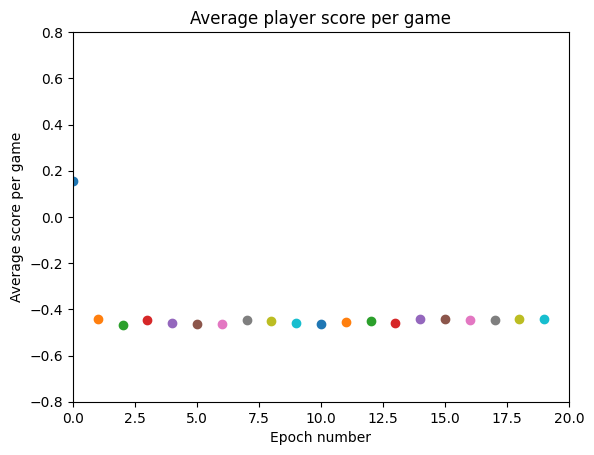

In [ ]:
# @markdown If you check `reset_training`, then all values  from training set will be reseted (q_dict, policies...)
reset_training = True # @param {"type":"boolean","placeholder":"Add more training"}
NUM_OF_EPOCH = 15 # @param {"type":"slider","min":1,"max":50,"step":1}
NUM_OF_GAMES = 6800 # @param {"type":"slider","min":100,"max":20000,"step":100}
ALPHA_PLAYER = 0.02 # @param {"type":"slider","min":0.01,"max":1,"step":0.01}
ALPHA_DEALER = 0.02 # @param {"type":"slider","min":0.01,"max":1,"step":0.01}
GAMMA = 0.5 # @param {"type":"slider","min":0.01,"max":1,"step":0.01}


env = Environment(number_of_decks=10)

if reset_training:
  q_dict = dict()         # PLAYER dict
  q_dict_dealer = dict()  # DEALER dict

  q_dict_best = dict()
  q_dict_dealer_best = dict()

  res_best = -float("inf")
  res_best_dealer = +float("inf")

  results = []

plt.axis([0, NUM_OF_EPOCH, -0.8, 0.8])
plt.xlabel("Epoch number")
plt.ylabel("Average score per game")

for epoch in trange(NUM_OF_EPOCH):

  player_policy = create_greedy_policy(q_dict, eps=0.15)
  new_dealer_policy = create_greedy_policy(q_dict_dealer, eps=0.05)

  player_exp, dealer_exp, average_score = simulate_multiple_games(player_policy,
                                              dealer_policy_new=new_dealer_policy,
                                              gamma=GAMMA,
                                              num_of_games=NUM_OF_GAMES,
                                              random_first_action=True)

  results.append(average_score)

  '''
    BEST DICT
  '''
  if average_score > res_best and q_dict:
    q_dict_best = copy.deepcopy(q_dict)
    res_best = average_score

  if average_score < res_best_dealer and q_dict_dealer:
    q_dict_dealer_best = copy.deepcopy(q_dict_dealer)
    res_best_dealer = average_score

  '''
    UPDATE DICT
  '''
  new_q_dict = get_q_values(player_exp)
  q_dict = update_q_dict(q_dict, new_q_dict, alpha=ALPHA_PLAYER)

  new_q_dict_dealer = get_q_values(dealer_exp)
  q_dict_dealer = update_q_dict(q_dict_dealer, new_q_dict_dealer, alpha=ALPHA_DEALER)

  '''
    DISPLAY
  '''

  display.clear_output(wait=True)
  plt.title("Average player score per game")
  plt.scatter(epoch, average_score)
  display.display(plt.gcf())
  sleep(0.05)

q_dict_last = copy.deepcopy(q_dict)
q_dict_dealer_last = copy.deepcopy(q_dict_dealer)
display.clear_output()

Testing

In [ ]:
print("Player vs New dealer:")
_,_,_ = simulate_multiple_games(create_greedy_policy(q_dict_best),
                                dealer_policy_new=new_dealer_policy,
                                gamma=0.5,
                                num_of_games=5000,
                                random_first_action = False,
                                report_callback=report_player_callback)

print("Dealer vs New dealer:")
_,_,_ = simulate_multiple_games(dealer_policy,
                                dealer_policy_new=new_dealer_policy,
                                gamma=0.5,
                                num_of_games=5000,
                                random_first_action = False,
                                report_callback=report_dealer_callback)

Player vs New dealer:

AGENT: Wins:25.68%, draws:12.62%, loses:61.7%  total_score:-1801 euros after 5000 rounds

AGENT: Average score per game is -0.3602

Dealer vs New dealer:

DEALER: Wins:39.9%, draws:12.12%, loses:47.98%  total_score:-404 euros after 5000 rounds

DEALER: Average score per game is -0.0808

In [ ]:
def play_real_game(player_policy: Policy,
                   dealer_policy: Policy,
                   num_of_games: int = 1000,
                   report_callback: ReportCallback | None = None):
  '''
    Plays the whole game, not from random state like in the training state
  '''
  report = lambda txt: report_callback and report_callback(txt)

  wins, draws, loses, total_score = 0, 0, 0, 0

  for game_num in trange(num_of_games):
    player_card = env.Hit()

    if player_card == 1:
      player_card = 11
      has_ace = True
    else:
      has_ace = False

    dealer_card = env.Hit()
    if dealer_card == 1:
      dealer_card = 11

    state = State(total=player_card,
                  has_ace=has_ace,
                  dealer_total=dealer_card)
    action = player_policy(state)
    score, log_player, log_dealer, _, _ = play_one_game(player_policy,
                                                     dealer_policy,
                                                     init_state = state,
                                                     init_action=action)


    if score == 1:
      wins += 1
    elif score == -1:
      loses += 1
    else:
      draws += 1

    total_score += score

  report(f"Player wins:{100*wins/num_of_games}%, draws:{100*draws/num_of_games}%, loses:{100*loses/num_of_games}%\
  total_score:{total_score} euros after {num_of_games} rounds")
  return wins, draws, loses


Playing real game, drawing cards one by one.\
Player versus new dealer policy

In [ ]:
message = play_real_game(create_greedy_policy(q_dict_best),
                         new_dealer_policy,
                         num_of_games=10000,
                         report_callback=report_player_callback)

100%|██████████| 10000/10000 [00:02<00:00, 4954.30it/s]


AGENT: Player wins:17.37%, draws:11.51%, loses:71.12%  total_score:-5375 euros after 10000 rounds

# Visualisation

In [ ]:
def visualize_policy(policy, is_dealer: bool = False):
    """Visualize the policy.

    The policy will be visualized using a colored grid.
    The horizontal axis will correspond to the player total and the vertical axis to the
    dealer's total.

    If a cell is colored in red, it means that the action is HIT, regardless of existence of usable ACE.
    If a cell is colored in blue, it means HOLD, regardless of existence of usable ACE.
    Green cells are those in which HIT will be played only if there is a usable ACE.
    Black cells are those in which HIT will be played only if there is no usable ACE.

    Since the last case (play HIT if there is no usable ACE, and HOLD otherwise) seems counterintutive,
    the color black is selected to distinguish it from other states.
    """
    player_values = list(range(2, 21))

    if is_dealer:
      biggest_sum = 22
    else:
      biggest_sum = 12
    dealer_values = list(range(2, biggest_sum))

    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if pv < 11:
                action_t = policy(State(pv, False, dv)) == Action.HIT
                if action_t:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                action_t = policy(State(pv, True, dv)) == Action.HIT
                action_f = policy(State(pv, False, dv)) == Action.HIT
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.imshow(board, extent=[2, 21, biggest_sum, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, biggest_sum +0.5, 1), np.arange(2, biggest_sum, 1))

    if is_dealer:
      plt.xlabel("dealer total")
      plt.ylabel("player total")
    else:
      plt.xlabel("player total")
      plt.ylabel("dealer total")

Text(0.5, 1.0, 'Delaer policy')

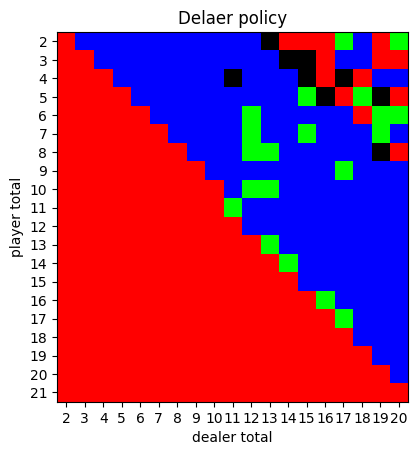

In [ ]:
visualize_policy(create_greedy_policy(q_dict_dealer_last), is_dealer=True)
plt.title("Delaer policy")

Text(0.5, 1.0, 'Player policy')

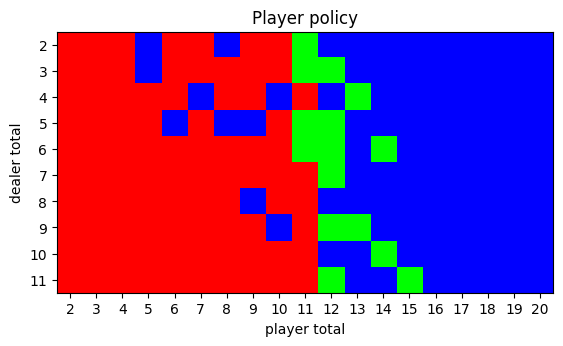

In [ ]:
visualize_policy(create_greedy_policy(q_dict_last))
plt.title("Player policy")